Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Accuracy: 0.51

Confusion Matrix:
 [[929 436 473]
 [449 936 453]
 [485 433 920]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.50      0.51      0.50      1838
           0       0.52      0.51      0.51      1838
           1       0.50      0.50      0.50      1838

    accuracy                           0.51      5514
   macro avg       0.51      0.51      0.51      5514
weighted avg       0.51      0.51      0.51      5514



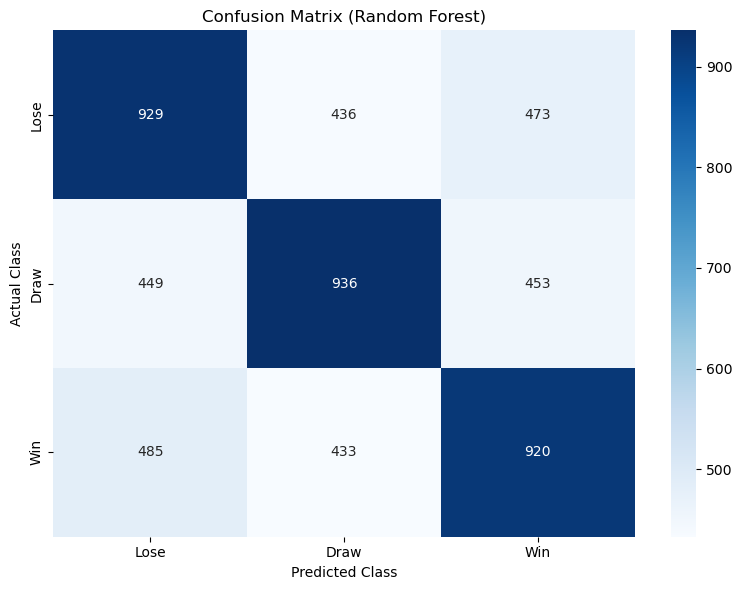

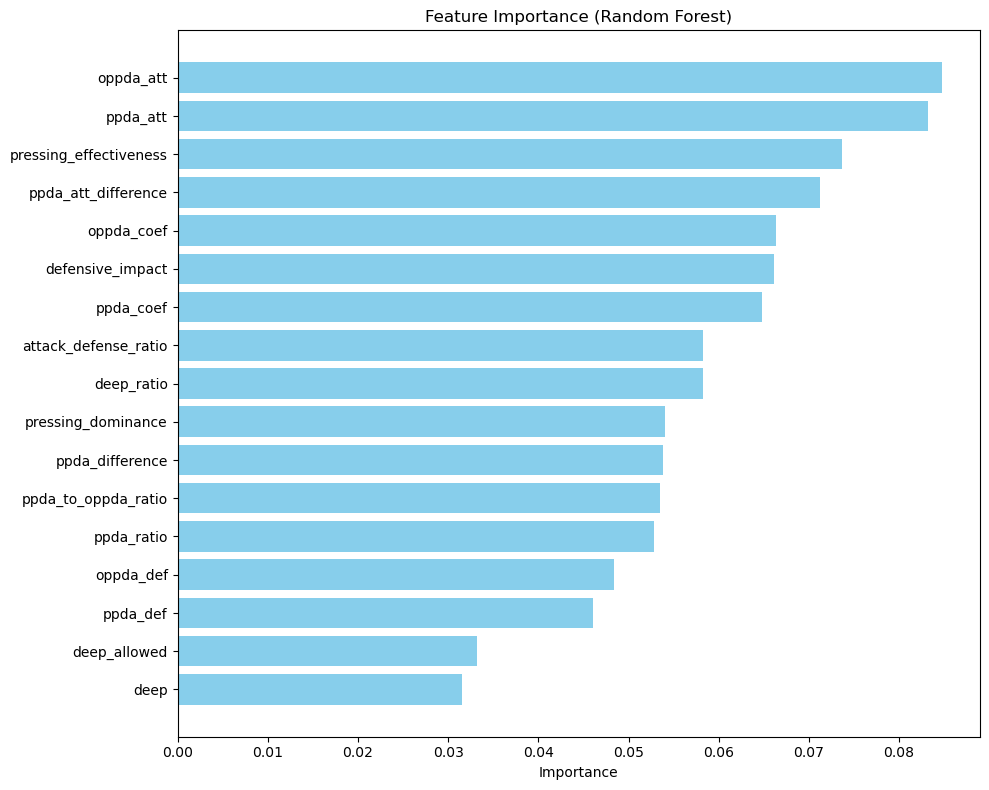

Feature Importances:

                   Feature  Importance
6                oppda_att    0.084731
4                 ppda_att    0.083218
12  pressing_effectiveness    0.073613
11     ppda_att_difference    0.071179
1               oppda_coef    0.066352
13        defensive_impact    0.066106
0                ppda_coef    0.064763
14    attack_defense_ratio    0.058236
8               deep_ratio    0.058228
15      pressing_dominance    0.054044
10         ppda_difference    0.053851
16     ppda_to_oppda_ratio    0.053514
9               ppda_ratio    0.052813
7                oppda_def    0.048426
5                 ppda_def    0.046099
3             deep_allowed    0.033246
2                     deep    0.031581


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and prepare the dataset
file_path = "understat_per_game.csv"  # Replace with your dataset path
dataset = pd.read_csv(file_path)

# Define tactical features and engineered features
tactical_features = [
    'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 
    'ppda_att', 'ppda_def', 'oppda_att', 'oppda_def'
]
target_variable = 'result'

# Encode target variable
result_mapping = {'w': 1, 'd': 0, 'l': -1}
dataset['result'] = dataset['result'].map(result_mapping)
dataset = dataset.dropna()

# Step 2: Feature Engineering
dataset['deep_ratio'] = dataset['deep'] / (dataset['deep_allowed'] + 1)  # Avoid division by zero
dataset['ppda_ratio'] = dataset['ppda_coef'] / (dataset['oppda_coef'] + 1)
dataset['ppda_difference'] = dataset['ppda_coef'] - dataset['oppda_coef']
dataset['ppda_att_difference'] = dataset['ppda_att'] - dataset['oppda_att']

dataset['pressing_effectiveness'] = dataset['ppda_coef'] * dataset['deep']
dataset['defensive_impact'] = dataset['ppda_def'] * dataset['deep_allowed']
dataset['attack_defense_ratio'] = dataset['deep'] / (dataset['deep_allowed'] + 1)
dataset['pressing_dominance'] = dataset['ppda_coef'] - dataset['oppda_coef']
dataset['ppda_to_oppda_ratio'] = dataset['ppda_coef'] / (dataset['oppda_coef'] + 1)

# Combine all features
features = tactical_features + [
    'deep_ratio', 'ppda_ratio', 'ppda_difference', 'ppda_att_difference',
    'pressing_effectiveness', 'defensive_impact', 'attack_defense_ratio',
    'pressing_dominance', 'ppda_to_oppda_ratio'
]

X = dataset[features]
y = dataset['result']

# Step 3: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 5: Grid Search with Class Weighting
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the Optimized Model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print(f"Optimized Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
classes = ['Lose', 'Draw', 'Win']  # Replace with actual class labels if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()

# Step 7: Feature Importance
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature Importances:\n")
print(importance_df)
